# Using Unigram Features Extracted from Abstracts to Predict Citation Count
##### Paul King

## Introduction

I attempted to use text features from abstracts to predict the number of citations that a paper would receive using regression models. Others have had successful results with similar methods; Baba & Baba (2018) used a classification model to predict whether abstracts would fall into the top or bottom percent of citation counts with 90% accuracy. I converted abstracts into unigram features and then scored with a selection of regression models and vectorizers and evaluated by Mean Squared Error and Coefficient of Determination (R2). However, none of the models performed better than random chance, with the highest R2 being 0.02 and an MSE of 23.47, using a Linear Regression Model, Binary Vectorizer and 100 max features. Increasing the number of features led to worse scores. I conclude that researchers cannot manipulate their abstracts to increase the number of citations their papers receive. Future models could potentially control for Field of Study to see if this results in more accurate predictions.

In [3]:
# Import necessary packages

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data Description

This is a dataset of papers and citations downloaded from https://www.aminer.org/citation (Tang et al, 2008). Papers and citations have a unique identifier linking them, which makes this dataset ideal for network analysis. Each paper also has a title and abstract which can be used for natural language processing. The abstracts and citations were harvested from various online resources. 

I used Version 10 of this Citation Network Dataset. This dataset contains 3,079,007 rows, each representing a paper, and 25,166,994 citations in total. Each row contains the following features: a unique ID, references that refer to said unique IDs, a title, author names, publishing year, and if available, an abstract and a venue where the paper was presented. I limited the dataset to the years from 2013 to 2018 inclusive, for a total of 980010 papers. The dataset is available as 4 JSON files, which I merged into a single dataframe.

In [ ]:
# Import and merge the 4 JSON files of the dataset, and limit it to years 2013 - 2018

df0 = pd.read_json('dblp-ref/dblp-ref-0.json',lines=True)
df1 = pd.read_json('dblp-ref/dblp-ref-1.json',lines=True)
df2 = pd.read_json('dblp-ref/dblp-ref-2.json',lines=True)
df3 = pd.read_json('dblp-ref/dblp-ref-3.json',lines=True)
new_df = pd.concat([df0,df1,df2,df3])
new_df2 = new_df[new_df['year'] > 2012]
new_df2.to_csv('20132018cite.csv')

In [3]:
# Import the concatenated dataset

raw_df = pd.read_csv('20132018cite.csv', usecols=["abstract","authors","references","title","venue","year","id"])
raw_df

,abstract,authors,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...","['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
1,NaN,"['Dominik Szajerman', 'Adam Jurczyński']","['3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe', 'bf3a...",Fur Visualisation for Computer Game Engines an...,international conference on computer vision an...,2014,00964544-cbe2-4da9-bb5a-03333160eb34
2,Recent achievements in Natural Language Proces...,"['Ankita Brahmachari', 'Priya Singh', 'Avdhesh...","['84d47128-58d0-4187-aa44-389fde7d5c83', 'e0dc...",Identifying Psychological Theme Words from Emo...,NaN,2013,00a119c4-d367-4607-b3c8-b237f2971bff
3,NaN,"['Abdullah Alsubaie', 'Antonio Di Pietro', 'Jo...","['0293844d-7244-4562-a6ca-d84bcd9c10a5', '14cd...",A Platform for Disaster Response Planning with...,NaN,2013,00e3940b-201b-40ba-bd20-dbdaf26ad324
4,"In recent years, most of mobile phones have a ...","['Hiroshi Furukawa', 'Yutaka Nakamura']","['b2f0e0d3-0071-4076-921e-f93f30160c1c', 'f030...",A pedestrian navigation method for user's safe...,international conference on human computer int...,2013,010d9907-45ef-459a-a293-8e1f41cef2b7
...,...,...,...,...,...,...,...
980005,NaN,"['Samantha Dick', ""Yvonne O'Connor"", 'Ciara He...",NaN,A Comparison of Mobile Health Evaluation Techn...,NaN,2017,ff5c13b5-6e3d-433f-8512-63c7ab0c8841
980006,NaN,"['Hassan Charaf', 'Peter Ekler', 'Tamás Mészár...",NaN,Mobile Platforms and Multi-Mobile Platform Dev...,Acta Cybernetica,2014,ff5ce050-ea8d-40e8-a25f-c629bed2ff9c
980007,NaN,"['Saul Blecker', 'Stuart D. Katz', 'Leora I. H...",NaN,Comparison of Approaches for Heart Failure Cas...,NaN,2016,ff5f5e4d-b650-496a-bfdd-91affb718488
980008,NaN,"['Dzmitry Bahdanau', 'Tom Bosc', 'Stanisław Ja...",NaN,Learning to Compute Word Embeddings on the Fly,NaN,2017,ff8fba62-4bf4-40cd-8555-46b8c64dddd7


## Exploratory Data Analysis

For Exploratory Data Analysis, I extracted Abstract Length, Number of Authors, Whether the paper was presented at a venue, and In-degree (number of citations) from the dataset. I extracted the in-degree using a library called NetworkX, which is used for network analysis and visualization. We want to see if there is a relationship between the features of papers and how many citations it will receive.

In [4]:
# Add abstract length (in words) to the dataset

def countabs(row):
    if type(row['abstract']) == str: # Only count Abstract Length for rows with abstract
        return len(row["abstract"].split())
    else:
        return 0

raw_df['abs_length'] = raw_df.apply(lambda row: countabs(row), axis=1)

In [40]:
# Count number of authors

def countauth(row):
    if type(row['authors']) == str:
        return (row["authors"].count(',') + 1)
    else:
        return 1 # Assume 1 author if blank

raw_df['author_count'] = raw_df.apply(lambda row: countauth(row), axis=1)

In [41]:
# Convert venue to binary

raw_df['venue_bin'] = raw_df.apply(lambda row: True if type(row['venue']) == str else False, axis=1)

In [5]:
# Create list of edges to copy into directed NetworkX graph
# We need to create tuples that specify sources (papers) and targets (citations). We will extract this from the "References" feature

edgelist = []
for index, row in raw_df.iterrows():
    if type(row['references']) == str:
        refs = row['references'][1:-1].split(', ') # References are stored as a string, which will need to be converted to a list
        for i in refs:
            edgelist.append((row["id"],i[1:-1]))
    
print("Our dataset contains %d edges (citations)" % len(edgelist))

Our dataset contains 10527185 edges (citations)


Using the list of edges, I created a Graph in NetworkX to calculate the in-degree for each paper. This graph is directed, because it has sources and targets, so there is a difference between the in-degree (how many times the paper was cited) and out-degree (how many times the paper cited other papers, which we are not interested in).

In [22]:
# Create a directed graph using NetworkX

G = nx.DiGraph()
G.add_edges_from(edgelist)

In [23]:
# Calculate the in-degree (number of times cited) for each paper

def indegree(row):
    return G.in_degree(row["id"])
 
raw_df['in-degree'] = raw_df.apply(lambda row: indegree(row), axis=1)
raw_df['in-degree'] = raw_df.apply(lambda row: 0 if type(row['in-degree']) != int else row['in-degree'], axis=1)

In [29]:
raw_df # We can take a look at what our new features look like

,abstract,authors,references,title,venue,year,id,author_count,venue_bin,in-degree
0,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...","['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,8,True,0
1,NaN,"['Dominik Szajerman', 'Adam Jurczyński']","['3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe', 'bf3a...",Fur Visualisation for Computer Game Engines an...,international conference on computer vision an...,2014,00964544-cbe2-4da9-bb5a-03333160eb34,2,True,0
2,Recent achievements in Natural Language Proces...,"['Ankita Brahmachari', 'Priya Singh', 'Avdhesh...","['84d47128-58d0-4187-aa44-389fde7d5c83', 'e0dc...",Identifying Psychological Theme Words from Emo...,NaN,2013,00a119c4-d367-4607-b3c8-b237f2971bff,4,False,0
3,NaN,"['Abdullah Alsubaie', 'Antonio Di Pietro', 'Jo...","['0293844d-7244-4562-a6ca-d84bcd9c10a5', '14cd...",A Platform for Disaster Response Planning with...,NaN,2013,00e3940b-201b-40ba-bd20-dbdaf26ad324,7,False,4
4,"In recent years, most of mobile phones have a ...","['Hiroshi Furukawa', 'Yutaka Nakamura']","['b2f0e0d3-0071-4076-921e-f93f30160c1c', 'f030...",A pedestrian navigation method for user's safe...,international conference on human computer int...,2013,010d9907-45ef-459a-a293-8e1f41cef2b7,2,True,0
...,...,...,...,...,...,...,...,...,...,...
980005,NaN,"['Samantha Dick', ""Yvonne O'Connor"", 'Ciara He...",NaN,A Comparison of Mobile Health Evaluation Techn...,NaN,2017,ff5c13b5-6e3d-433f-8512-63c7ab0c8841,3,False,0
980006,NaN,"['Hassan Charaf', 'Peter Ekler', 'Tamás Mészár...",NaN,Mobile Platforms and Multi-Mobile Platform Dev...,Acta Cybernetica,2014,ff5ce050-ea8d-40e8-a25f-c629bed2ff9c,8,True,0
980007,NaN,"['Saul Blecker', 'Stuart D. Katz', 'Leora I. H...",NaN,Comparison of Approaches for Heart Failure Cas...,NaN,2016,ff5f5e4d-b650-496a-bfdd-91affb718488,6,False,0
980008,NaN,"['Dzmitry Bahdanau', 'Tom Bosc', 'Stanisław Ja...",NaN,Learning to Compute Word Embeddings on the Fly,NaN,2017,ff8fba62-4bf4-40cd-8555-46b8c64dddd7,6,False,0


In [30]:
raw_df.to_csv('citation_indegree.csv') # We will save our dataset with our new features added

In [28]:
raw_df2 = pd.read_csv('citation_indegree.csv',usecols=["abstract","author_count","references","title","venue_bin","year","id","in-degree"])

I used NetworkX's Draw functionality to create network visualizations, limiting our sample size and in-degree. Larger sample sizes and in-degree would take a very long time to compute and be very difficult to understand.

C:\Users\Paul K\AppData\Local\Temp\ipykernel_17120\3951954045.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  net_df = raw_df2[raw_df2['in-degree'] < 20][raw_df2['in-degree'] > 5].sample(n=15)


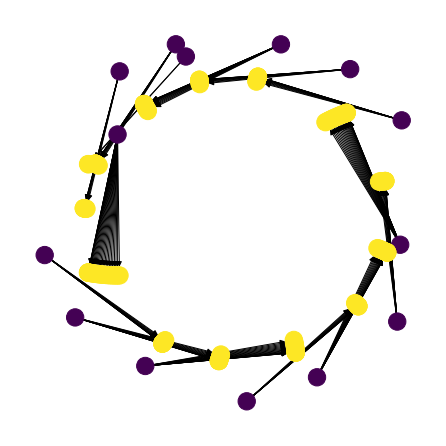

In [47]:
# Building a visualization

net_df = raw_df2[raw_df2['in-degree'] < 20][raw_df2['in-degree'] > 5].sample(n=15) # Limit in-degree and take a sample

edgelist = []
for index, row in net_df.iterrows():
    if type(row['references']) == str:
        refs = row['references'][1:-1].split(', ')
        for i in refs:
            edgelist.append((row["id"],i[1:-1]))

G = nx.DiGraph() # We're creating a new, smaller graph from our sample to speed things up
G.add_edges_from(edgelist)

plt.rcParams["figure.figsize"] = (6,6)
degrees = G.in_degree()
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes]) # Colour nodes by in-degree
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=n_color)

In a small network visualization, we can see that there isn't a lot of intersection between edges. Most of our papers are either cited in our dataset, but do not cite other papers in the dataset, or cite a paper but do not get cited elsewhere. This could be because the analysis is limited to the years 2013-2018; extrapolating what we see here, with a greater range of years, we might potentially see that papers that are cited by many papers, in turn, cite papers that are cited by many papers.

Larger network visualizations are exponentially slower to compute. They are also much more difficult to interpret, being too busy and complicated to understand. I created another visualization with a slightly larger sample and a different layout to demonstrate this.

C:\Users\Paul K\AppData\Local\Temp\ipykernel_15268\2860716615.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  net_df = raw_df2[raw_df2['in-degree'] < 20][raw_df2['in-degree'] > 5].sample(n=50) # Limit in-degree and take a sample


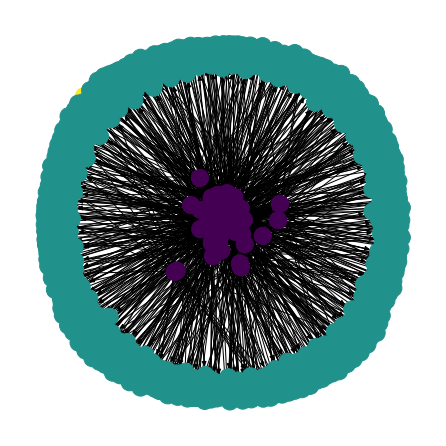

In [33]:
net_df = raw_df2[raw_df2['in-degree'] < 20][raw_df2['in-degree'] > 5].sample(n=50) # Limit in-degree and take a sample

edgelist = []
for index, row in net_df.iterrows():
    if type(row['references']) == str:
        refs = row['references'][1:-1].split(', ')
        for i in refs:
            edgelist.append((row["id"],i[1:-1]))

G = nx.DiGraph() # We're creating a new, smaller graph from our sample to speed things up
G.add_edges_from(edgelist)

plt.rcParams["figure.figsize"] = (6,6)
degrees = G.in_degree()
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes]) # Colour nodes by in-degree
nx.draw(G, pos=nx.spring_layout(G), node_color=n_color)

I also examined in-degree versus abstract length, number of authors, and whether it was presented at a venue.

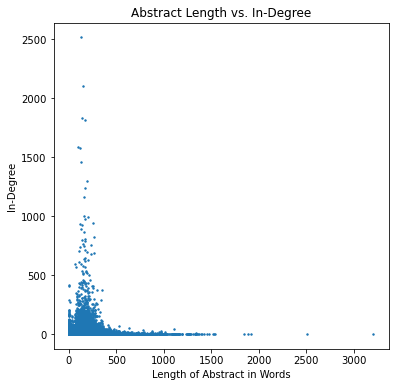

In [8]:
plt.rcParams["figure.figsize"] = (6,6)
plt.xlabel("Length of Abstract in Words")
plt.ylabel("In-Degree")
plt.title("Abstract Length vs. In-Degree")
plt.scatter(raw_df2["abs_length"],raw_df2["in-degree"], s = 2)

From the Abstract Length chart, we see that there are a number of outliers for in-degree and abstract length. It's possible that there is an inverse relationship between Abstract Length and In-degree, but it is difficult to tell due to the amount of noise.

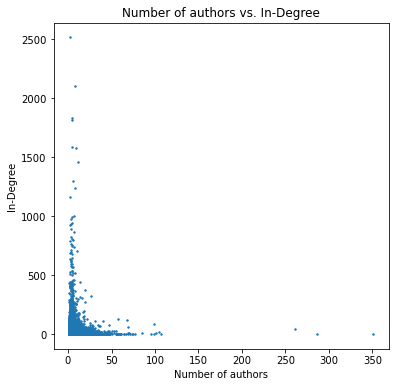

In [35]:
plt.rcParams["figure.figsize"] = (6,6)
plt.xlabel("Number of authors")
plt.ylabel("In-Degree")
plt.title("Number of authors vs. In-Degree")
plt.scatter(raw_df2["author_count"],raw_df2["in-degree"], s = 2)

Comparing number of authors with in-degree, we again see that there are a number of outliers, but it's not clear if there's an inverse relationship.

Mean in-degree of papers presented at a venue: 2.624111695918409
Mean in-degree of papers not presented at a venue: 0.964457146307347


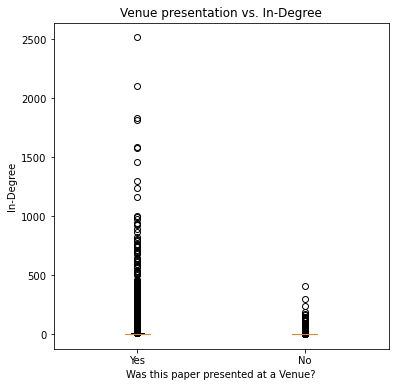

In [33]:
plt.rcParams["figure.figsize"] = (6,6)
plt.xlabel("Was this paper presented at a Venue?")
plt.ylabel("In-Degree")
plt.title("Venue presentation vs. In-Degree")
x1 = raw_df2["in-degree"][raw_df2["venue_bin"]==True]
x2 = raw_df2["in-degree"][raw_df2["venue_bin"]==False]
plt.boxplot([x1,x2])
plt.xticks([1,2],['Yes','No'])
print("Mean in-degree of papers presented at a venue: " + str(x1.mean()))
print("Mean in-degree of papers not presented at a venue: " + str(x2.mean()))

We do see that the mean in-degree for papers not presented at a venue is lower, however this is complicated by the large number of outliers.

Based on the Exploratory Data Analysis, I needed to omit outliers from the regression model. I also chose to test my regression model both controlling and without controlling for abstract length, number of authors, and venue presentation, to see if this improved the model's performance.

In [29]:
raw_df2.describe()

,year,author_count,in-degree
count,980010.000000,980010.000000,980010.000000
mean,2014.737341,3.487893,2.287534
std,1.267870,1.981561,10.141657
min,2013.000000,1.000000,0.000000
25%,2014.000000,2.000000,0.000000
50%,2015.000000,3.000000,0.000000
75%,2016.000000,4.000000,2.000000
max,2018.000000,351.000000,2515.000000


## Research Question

We would like to see if there is a way to predict how many citations a paper will get, and if we can offer recommendations to researchers on how to improve their abstracts to increase their number of citations and the impact of their publications. Abstracts are free, open-access, and provide an easy-to-read summary of papers, so it follows that a well-written abstract could receive more citations. Given the lack of a clear relationship between the extracted features, and that we have this large corpus of abstracts, we can ask: Can we predict the number of citations a paper will have based on text features of our abstracts? I will use regression models to see if the in-degree (number of citations) for a given paper can be predicted using unigram (single-word) features extracted from its abstract.

In [2]:
raw_df = pd.read_csv('citation_indegree.csv')
raw_df.head()

,Unnamed: 0,abstract,authors,references,title,venue,year,id,author_count,venue_bin,in-degree
0,0,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...","['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,8,True,0
1,1,NaN,"['Dominik Szajerman', 'Adam Jurczyński']","['3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe', 'bf3a...",Fur Visualisation for Computer Game Engines an...,international conference on computer vision an...,2014,00964544-cbe2-4da9-bb5a-03333160eb34,2,True,0
2,2,Recent achievements in Natural Language Proces...,"['Ankita Brahmachari', 'Priya Singh', 'Avdhesh...","['84d47128-58d0-4187-aa44-389fde7d5c83', 'e0dc...",Identifying Psychological Theme Words from Emo...,NaN,2013,00a119c4-d367-4607-b3c8-b237f2971bff,4,False,0
3,3,NaN,"['Abdullah Alsubaie', 'Antonio Di Pietro', 'Jo...","['0293844d-7244-4562-a6ca-d84bcd9c10a5', '14cd...",A Platform for Disaster Response Planning with...,NaN,2013,00e3940b-201b-40ba-bd20-dbdaf26ad324,7,False,4
4,4,"In recent years, most of mobile phones have a ...","['Hiroshi Furukawa', 'Yutaka Nakamura']","['b2f0e0d3-0071-4076-921e-f93f30160c1c', 'f030...",A pedestrian navigation method for user's safe...,international conference on human computer int...,2013,010d9907-45ef-459a-a293-8e1f41cef2b7,2,True,0


## Methods

The abstracts were preprocessed with a library called Natural Language Toolkit or NLTK, in order to prepare them for vectorization and regression. I removed non-alphabetic characters, converted to lowercase, tokenized words (convert to list), removed stopwords that will not contribute to the model's accuracy, converted to stems, and rejoined to a string. This leaves the abstracts in a uniform format.

In [ ]:
# Import and download necessary components for preprocessing

import re # Regex package
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [6]:
# Preprocess text
processed_df = raw_df.copy()
processed_df = processed_df.drop(processed_df[processed_df['abs_length'] == 0].index) # Remove papers with no abstract

def preprocess(row):
    row['abstract'] = re.sub('[^A-Za-z]', ' ', row['abstract']) # Remove punctuation and numbers
    row['abstract'] = row['abstract'].lower()
    row['abstract'] = word_tokenize(row['abstract']) # Convert to list
    for word in row['abstract']: # Remove common English stopwords
        if word in stopwords.words('english'):
            row['abstract'].remove(word)
    return row['abstract']

processed_df['abstract'] = processed_df.apply(lambda row: preprocess(row), axis=1)
processed_df['stemmed'] = processed_df['abstract'].apply(lambda x: [stemmer.stem(word) for word in x]) # Convert words to stems
processed_df['abs_processed'] = processed_df['stemmed'].apply(lambda x: " ".join(x))

processed_df

,Unnamed: 0,abstract,authors,n_citation,references,title,venue,year,id,abs_length,in-degree,stemmed,abs_processed
0,0,"[purpose, this, study, develop, learning, tool...","['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,60,0,"[purpos, thi, studi, develop, learn, tool, hig...",purpos thi studi develop learn tool high schoo...
2,2,"[recent, achievements, natural, language, proc...","['Ankita Brahmachari', 'Priya Singh', 'Avdhesh...",0,"['84d47128-58d0-4187-aa44-389fde7d5c83', 'e0dc...",Identifying Psychological Theme Words from Emo...,NaN,2013,00a119c4-d367-4607-b3c8-b237f2971bff,225,0,"[recent, achiev, natur, languag, process, nlp,...",recent achiev natur languag process nlp psycho...
4,4,"[recent, years, mobile, phones, function, pede...","['Hiroshi Furukawa', 'Yutaka Nakamura']",7,"['b2f0e0d3-0071-4076-921e-f93f30160c1c', 'f030...",A pedestrian navigation method for user's safe...,international conference on human computer int...,2013,010d9907-45ef-459a-a293-8e1f41cef2b7,129,0,"[recent, year, mobil, phone, function, pedestr...",recent year mobil phone function pedestrian na...
6,6,"[number, alternative, techniques, dealing, unc...","['Theresa Beaubouef', 'Frederick E. Petry']",0,"['09b666de-6279-486c-beb2-f56881de7a0f', '1aeb...",Information Systems Uncertainty Design and Imp...,NaN,2014,01edeac9-cd8b-46f9-a8a8-25445b959abc,46,0,"[number, altern, techniqu, deal, uncertainti, ...",number altern techniqu deal uncertainti we dis...
8,8,"[breast, cancer, common, form, cancer, women, ...","['Bartosz Krawczyk', 'Gerald Schaefer', 'Shao ...",50,"['16f0341b-538d-40f3-996c-8de7cc4dc675', '1ca1...",Breast Cancer Identification Based on Thermal ...,NaN,2013,0265aea8-65f3-4f46-b8b1-6b65bcb1d38f,215,1,"[breast, cancer, common, form, cancer, women, ...",breast cancer common form cancer women earli d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979954,979954,"[analyse, problem, aggregating, judgments, mul...","['Irem Bozbay', 'Franz Dietrich', 'Hans Peters']",0,NaN,Judgment aggregation in search for the truth,NaN,2014,fab4bc37-adaf-46a8-928f-cb232d14a574,136,0,"[analys, problem, aggreg, judgment, multipl, i...",analys problem aggreg judgment multipl issu pe...
979963,979963,"[utilization, icts, creating, new, jobs, elimi...","['Marios Pappas', 'Yannis Papagerasimou', 'Ath...",0,NaN,ICT-based Innovation and Employability for Women,NaN,2017,fb60d6a0-ac9f-40cf-a4b7-9dfbcd0951e7,98,0,"[util, ict, creat, new, job, elimin, gender, b...",util ict creat new job elimin gender base ineq...
979970,979970,"[infinite, horizon, inventory, sales, model, s...","['Anita van den Berg', 'Jean-Jacques Herings',...",0,"['35a8f1b8-4e51-4928-9603-1f6a1872d02b', '460f...",The economic order decision with continuous dy...,Operations Research Letters,2017,fc0809cd-e8b5-4f50-a929-e09312c59fe0,50,0,"[infinit, horizon, inventori, sale, model, sho...",infinit horizon inventori sale model show the ...
979975,979975,"[infrared, imaging, technology, used, study, d...","['Michele Dei', 'Stepan Sutula', 'Jose Cisnero...",0,NaN,A Robust 96.6-dB-SNDR 50-kHz-Bandwidth Switche...,Sensors,2017,fc27af72-9f8c-4bda-8f19-11100096ae59,165,0,"[infrar, imag, technolog, use, studi, deep, sp...",infrar imag technolog use studi deep space bod...


In [7]:
# save preprocessed df for later
processed_df.to_csv('processed_df.csv')

In [4]:
processed_df = pd.read_csv("processed_df2.csv",usecols=['year','abs_length','abs_processed','author_count','venue_bin','in-degree'])
processed_df

,year,abs_length,in-degree,abs_processed,author_count,venue_bin
0,2013,41,0,purpos thi studi develop learn tool high schoo...,8,True
1,2013,155,0,recent achiev natur languag process nlp psycho...,4,False
2,2013,86,0,recent year mobil phone function pedestrian na...,2,True
3,2014,33,0,number altern techniqu deal uncertainti we dis...,2,False
4,2013,147,1,breast cancer common form cancer women earli d...,3,False
...,...,...,...,...,...,...
783528,2014,90,0,analys problem aggreg judgment multipl issu pe...,3,False
783529,2017,66,0,util ict creat new job elimin gender base ineq...,5,False
783530,2017,37,0,infinit horizon inventori sale model show the ...,3,True
783531,2017,140,0,infrar imag technolog use studi deep space bod...,7,True


With the preprocessed abstracts, I vectorized the abstracts (converted into features that the regression model can understand) and put them into the model.

In order to find the most accurate model, I selected several different parameters:

Vectorizer: Count, Binary, TF-IDF (Term Frequency-Inverse Document Frequency)

Max Features: 100, 500, 1000

Model: Linear Regression, Support Vector Regression, Decision Tree


I created an algorithm to test every variation of these parameters, and score them based on Mean Squared Error and Coefficient of Determination.

In [9]:
# Import libraries for regression and evaluation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 

In [71]:
# Algorithm to test models

def model_eval(vectorizer,features,model,sample):
    sub_df = processed_df[processed_df['in-degree'] < 35][processed_df['in-degree'] > 0].sample(n=sample) # Limit in-degree and sample dataset

    # Determine vectorizer
    if vectorizer == "count":
        matrix = CountVectorizer(max_features=features)
    elif vectorizer == "binary":
        matrix = CountVectorizer(max_features=features, binary=True)
    elif vectorizer == "tfidf":
        matrix = TfidfVectorizer(max_features=features)

    # Split data into train-test split, 75-25%
    X = matrix.fit_transform(sub_df['abs_processed'].values.astype('U')).toarray()
    y = sub_df.loc[:, ['in-degree']]
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Determine and fit model
    if model == "linear":
        regressor = LinearRegression()
    elif model == "svr":
        regressor = SVR()
    elif model == "tree":
        regressor = DecisionTreeRegressor(random_state = 0) 
    regressor.fit(X_train,y_train)
    
    # Evaluate model and return scores
    y_pred = regressor.predict(X_test)
    print("Model: " + str(model))
    print("Vectorizer: " + str(vectorizer))
    print("Max features: " + str(features))
    print("Sample n = " + str(sample))
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    print("\n")


In [76]:
import warnings
warnings.filterwarnings('ignore') # Suppress user warnings to make the output more legible

vectorizers = ["count","binary","tfidf"]
models = ["linear","svr","tree"]
features = [100,500,1000]

for v in vectorizers:
    for m in models:
        for f in features:
            model_eval(v,f,m,10000)

Model: linear
Vectorizer: count
Max features: 100
Sample n = 10000
Mean squared error: 24.75
Coefficient of determination: 0.01


Model: linear
Vectorizer: count
Max features: 500
Sample n = 10000
Mean squared error: 22.96
Coefficient of determination: -0.06


Model: linear
Vectorizer: count
Max features: 1000
Sample n = 10000
Mean squared error: 29.67
Coefficient of determination: -0.12


Model: svr
Vectorizer: count
Max features: 100
Sample n = 10000
Mean squared error: 29.71
Coefficient of determination: -0.13


Model: svr
Vectorizer: count
Max features: 500
Sample n = 10000
Mean squared error: 27.06
Coefficient of determination: -0.09


Model: svr
Vectorizer: count
Max features: 1000
Sample n = 10000
Mean squared error: 28.51
Coefficient of determination: -0.10


Model: tree
Vectorizer: count
Max features: 100
Sample n = 10000
Mean squared error: 48.05
Coefficient of determination: -1.35


Model: tree
Vectorizer: count
Max features: 500
Sample n = 10000
Mean squared error: 53.57
Co

A full table of these results is available in the appendix.

All of these models performed similarly with coefficient of determination around 0, with the exception of the Decision Tree Regressor which performed significantly worse. The best-performing model was the Linear Regression Model, Binary Vectorizer and 100 features. I tested this model on the entire dataset with a 5-fold cross-validation.

In [14]:
# cross validation test
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

sub_df = processed_df[processed_df['in-degree'] < 35][processed_df['in-degree'] > 0]
matrix = CountVectorizer(max_features=100, binary=True)
X = matrix.fit_transform(sub_df['abs_processed'].values.astype('U')).toarray()
y = sub_df.loc[:, ['in-degree']]

regressor = LinearRegression()

cv = KFold(n_splits=5, random_state=1, shuffle=True)
mse_scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv = cv)
r2_scores = cross_val_score(regressor, X, y, scoring='r2', cv = cv)

print("Model: Linear Regression")
print("Vectorizer: Binary")
print("Max features: 100")
print("Sample n = full dataset")
print("Cross-validation: 5 k-fold")
print("Mean squared error: %.2f" % mean(absolute(mse_scores)))
print("Coefficient of determination: %.2f" % mean(r2_scores))

C:\Users\Paul K\AppData\Local\Temp\ipykernel_7588\2160277117.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df = processed_df[processed_df['in-degree'] < 35][processed_df['in-degree'] > 0]


Model: Linear Regression
Vectorizer: Binary
Max features: 100
Sample n = full dataset
Cross-validation: 5 k-fold
Mean squared error: 23.47
Coefficient of determination: 0.02


I also tested this model on a second version of the dataset which controls for Abstract Length, Author Count and Venue Presentation. This model scored worse, compared to the full dataset.

In [15]:
# cross validation test
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute

sub_df = processed_df[processed_df['in-degree'] < 35][processed_df['in-degree'] > 0]
sub_df = sub_df[sub_df['abs_length'] < 250][sub_df['abs_length'] > 0]
sub_df = sub_df[sub_df['author_count'] < 10]
sub_df = sub_df[sub_df['venue_bin'] == True]
matrix = CountVectorizer(max_features=100, binary=True)
X = matrix.fit_transform(sub_df['abs_processed'].values.astype('U')).toarray()
y = sub_df.loc[:, ['in-degree']]

regressor = LinearRegression()

cv = KFold(n_splits=5, random_state=1, shuffle=True)
mse_scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv = cv)
r2_scores = cross_val_score(regressor, X, y, scoring='r2', cv = cv)

print("Model: Linear Regression")
print("Vectorizer: Binary")
print("Max features: 100")
print("Sample n = full dataset with controls")
print("Cross-validation: 5 k-fold")
print("Mean squared error: %.2f" % mean(absolute(mse_scores)))
print("Coefficient of determination: %.2f" % mean(r2_scores))

C:\Users\Paul K\AppData\Local\Temp\ipykernel_7588\2583468257.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df = processed_df[processed_df['in-degree'] < 35][processed_df['in-degree'] > 0]
C:\Users\Paul K\AppData\Local\Temp\ipykernel_7588\2583468257.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df = sub_df[sub_df['abs_length'] < 250][sub_df['abs_length'] > 0]


Model: Linear Regression
Vectorizer: Binary
Max features: 100
Sample n = full dataset with controls
Cross-validation: 5 k-fold
Mean squared error: 24.83
Coefficient of determination: 0.02


## Discussion

Based on the performance of these models, there doesn’t seem to be any relation between the unigram frequencies of an abstract and the number of citations it will receive. Our best performing dataset (Linear Regression, Binary Vectorizer, 100 Features, Full Dataset) returned an MSE of 23.47 and a coefficient of determination of 0.02. These results are no better than random chance. Interestingly, increasing the number of features led to worse scores. Support Vector Regression models also did not perform any better, in spite of the significantly longer computation time. I conclude, reassuringly, that researchers cannot manipulate their abstracts using specific terms in order to increase the number of citations they receive.

## Limitations

Due to a lack of computing power and time, many of my models were only run on a sample size of 10000. As well, features were selected on the basis of frequency, which does not necessarily mean that they would have the best predictive power. Because I only calculated the in-degree of a subset of the data, the actual number of citations could be higher than what is presented here. As well, it's possible that papers from a different set of years would look different. An older network of papers would have a different distribution of in-degree, owing to the fact that scholars would have more time to read and evaluate these papers and publish their own papers. Finally, there were a large number of confounding factors I was not able to control for, including the quality of the papers, their field of study, and what journal they were published in.

## Future Directions

Future directions could be looking for other text features, such as calculating sentiment, to see if those correlate with in-degree. Version 13 of the Citation Network Dataset contains a string field for Field of Study, and we could control for field of study to see if we can predict in-degree better this way. We could also use this version in order to develop a classification model that can predict the field of study of a given paper based on text features. Given the amount of field-specific terminology in academic papers, we might hypothesize that such a classification model would score well.

## References

Baba, T., & Baba, K. (2018). Citation Count Prediction Using Non-technical Terms in Abstracts. Computational Science and Its Applications – ICCSA 2018, 366–375. https://doi.org/10.1007/978-3-319-95162-1_25

Tang, J., Zhang, J., Yao, L., Li, J., Zhang, L., & Su, Z. (2008). ArnetMiner: extraction and mining of academic social networks. Proceedings of the 14th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 990–998. https://doi.org/10.1145/1401890.1402008


## Appendix A. Regression Results

In [16]:
print(pd.read_csv("model_eval_results.csv"))

     Model Vectorizer  Max Features    MSE    R2                 Sample
0   Linear     Binary           100  23.47  0.02           Full Dataset
1   Linear     Binary           100  24.83  0.02  Dataset with Controls
2   Linear     Binary           100  22.74  0.01                  10000
3   Linear      Count           100  24.75  0.01                  10000
4   Linear     TF-IDF           100  25.11  0.00                  10000
5   Linear     Binary           500  25.50 -0.02                  10000
6   Linear     TF-IDF           500  24.55 -0.03                  10000
7   Linear      Count           500  22.96 -0.06                  10000
8      SVR     Binary          1000  24.03 -0.09                  10000
9      SVR     Binary           500  25.80 -0.09                  10000
10     SVR      Count           500  27.06 -0.09                  10000
11     SVR      Count          1000  28.51 -0.10                  10000
12     SVR     TF-IDF          1000  26.20 -0.11                

## Appendix B. Alternate method

In order to explore alternatives to the methods presented above, I attempted a Linear Regression model using the alternate features of Author Count, Abstract Length and Venue Presentation, and compared it with the best-performing text feature model. This model did not out-perform the text feature model. As such, I am presenting it as an appendix.

In [5]:
sub_df = raw_df[raw_df['in-degree'] < 35][raw_df['in-degree'] > 0][raw_df['abs_length'] > 0]
X = sub_df.loc[:, ['author_count','venue_bin','abs_length']]
y = sub_df.loc[:, ['in-degree']]
X_train, X_test, y_train, y_test = train_test_split(X, y)
regressor = LinearRegression()
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)
print("Model: Linear Regression")
print("Sample n = full dataset")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

C:\Users\Paul K\AppData\Local\Temp\ipykernel_21856\2970326407.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_df = raw_df[raw_df['in-degree'] < 35][raw_df['in-degree'] > 0][raw_df['abs_length'] > 0]


Model: Linear Regression
Sample n = full dataset
Mean squared error: 23.52
Coefficient of determination: 0.01
